---
<div align="center">

# Lung Cancer Classification with

CT [Computerized Tomography] Data
-
</div>

---

---
## Index
---

> INSERT PROJECT INDEX HERE

---
## Problem Formulation
---

### Context

Lung cancer remains the leading cause of cancer-related mortality worldwide. Unfortunately, only 16% of cases are diagnosed at an early, localized stage, where patients have a five-year survival rate exceeding 50%. When lung cancer is identified at more advanced stages, the survival rate plummets to just 5%.

Given this stark difference, early diagnosis is critical for improving patient outcomes. Non-invasive imaging methods, such as computed tomography (CT), have proven effective in providing crucial information regarding tumor status. This opens opportunities for developing computer-aided diagnosis (CAD) systems capable of assessing the malignancy risk of lung nodules and supporting clinical decision-making.

### Resolution Approach

Due to factors like high inter-observer variability in visual assessments and the large volumes of radiological data to be analyzed, developing fully automated diagnostic systems is increasingly appealing.

The goal of this project is to create a machine learning-based solution for classifying lung nodules as benign or malignant using CT images. The publicly available LIDC-IDRI dataset, containing expertly annotated CT scans of the human torso, will serve as the primary data source. By employing advanced feature extraction techniques (e.g., radiomics) and modern machine learning algorithms, the aim is to accurately predict the malignancy of detected nodules.

### Planned Work

The project will involve several key steps, including:

- ``Data Preprocessing`` : Cleaning and preparing the CT scan data to ensure its quality and consistency for further analysis.
- ``Feature Engineering`` : Leveraging radiomics and deep learning techniques to extract meaningful features from the scans.
- ``Model Development`` : Training and fine-tuning machine learning models to accurately classify lung nodules based on their malignancy status.
- ``Performance Evaluation`` : Assessing model performance using key metrics such as accuracy and AUC, and validating results through robust methods such as k-fold cross-validation.
  
The ultimate objective of this automated classification system is to aid in clinical decision-making, offering a supplementary screening tool that reduces the workload on radiologists while improving early detection rates for lung cancer.

---
## Project Dependencies
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import os
from pprint import (pprint)
import radiomics
from radiomics import (featureextractor)
import customPylidc as pl
from customPylidc import (ClusterError)
from FeatureExtraction import (extractPyradiomicsFeatures)
from Utils.DataVisualization import (plot_feature_distribution)

---
## Data Preprocessing
---

This section focuses on the extraction, analysis, and cleaning of the CT scan data from the LIDC-IDRI dataset, making use of the pylidc and pyradiomics libraries.

### LIDC-IDRI Dataset

The LIDC-IDRI is a lung cancer screening dataset which comprises thoracic CT scans for a total of 1010 patients, alongside annotated nodules belonging to one of three classes: 

<table>
  <tr>
    <th colspan="2">Nodules Classification</th>
  </tr>
  <tr>
    <th>Class Label</th>
    <th>Diameter</th>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Nodule</td>
    <td>$$ < \space 3 \space mm$$</td>
  </tr>
  <tr>
    <td align="center">Non-Nodule</td>
    <td>$$ \ge \space 3 \space mm$$</td>
  </tr>
</table>

These annotations were performed through a two-phase process by four experienced radiologists. In addition to the CT images, the dataset provides annotations on malignancy, nodule/non-nodule locations, and clinical information about the patients.

This dataset contains a standardized DICOM representation of the annotations and characterizations gathered by the LIDC/IDRI initiative, which were originally stored in XML format. Only nodules with a largest planar dimension of 3 mm or greater have been annotated and characterized by expert radiologists, and only these nodules are included in the current dataset.

The conversion was facilitated by the pylidc library, which handles XML parsing, volumetric reconstruction of the nodule annotations, clustering of annotations for the same nodule, and the calculation of nodule volume, surface area, and largest diameter.

---
### Initial Data Analysis
---

In this initial phase, we will focus on analyzing the data available in the pylidc package to gain deeper insights into how we can utilize this information to later detect nodule malignancy using machine learning algorithms.

After thoroughly reviewing the pylidc package documentation, we discovered that each patient is associated with a Scan, which may include multiple nodule annotations from different doctors who aimed to accurately identify the malignancy stage of the nodules within each CT Scan.

---
#### Population Dimensions
---

We decided to begin by analyzing the characteristics of the population, specifically focusing on the number of patients, scans and annotations.

In [4]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [5]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [6]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


---
#### [LIDC-IDRI-0001] Patient Nodule Visualization
---

Then, we wanted to visualize how the first patient nodule's data looked like.

In [17]:
# Choose a patient ID
pid = 'LIDC-IDRI-0005'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0005's Scan has 3 Nodule(s)


In [18]:
# Patient Nodules
nods = scan.cluster_annotations()

print("%s has %d nodules." % (scan, len(nods)))
# => Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.

for i, nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))
# => Nodule 1 has 4 annotations.
# => Nodule 2 has 4 annotations.
# => Nodule 3 has 1 annotations.
# => Nodule 4 has 4 annotations.

Scan(id=16,patient_id=LIDC-IDRI-0005) has 3 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.


Loading dicom files ... This may take a moment.


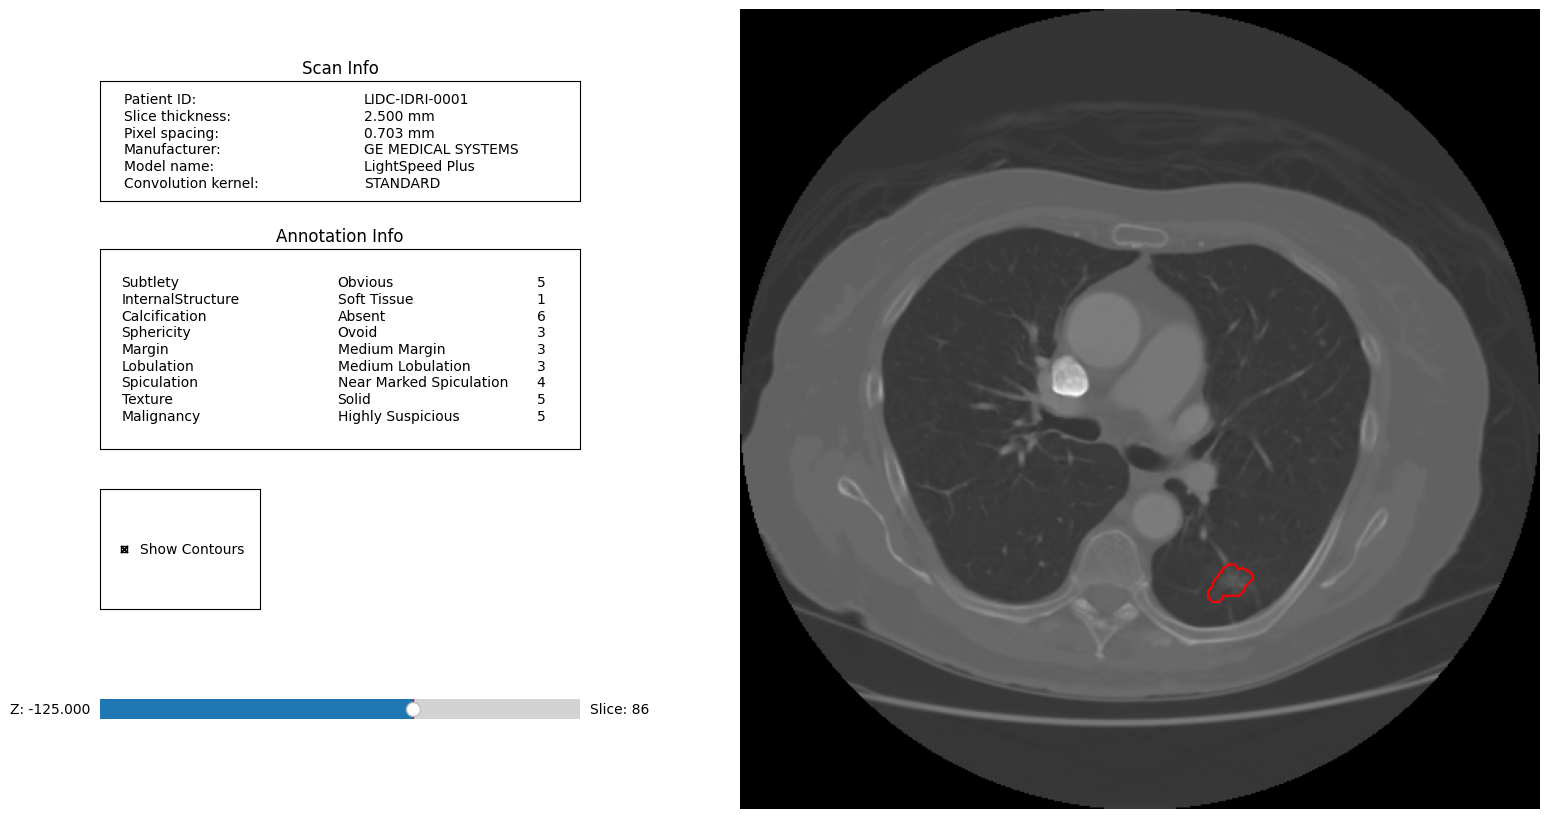

In [9]:
# Visualize the CT Scan
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


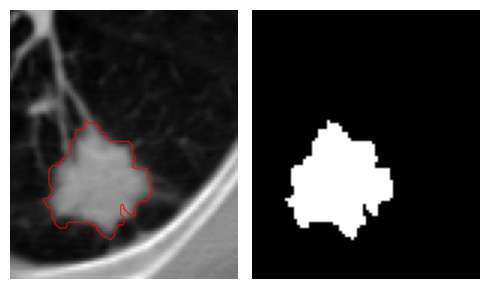

In [10]:
# Plot the Nodule's Mask
ann.visualize_nodule_mask()

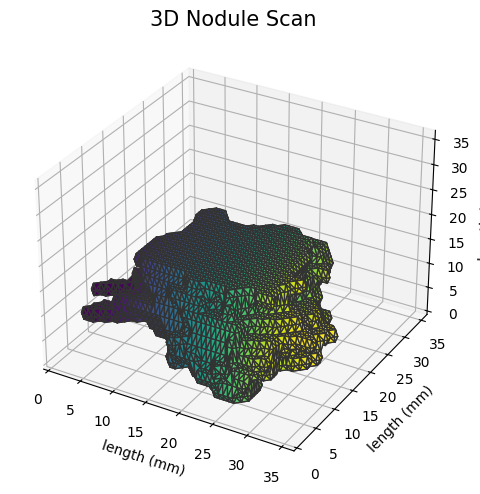

In [11]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
### [PyLIDC] Features Dataset
---

> The package contains the semantical features

> ADD A DESCRIPTION OF THE PACKAGE [ITS CONTENTS] AND WHAT IT ENABLED US TO DO

---
#### [PyLIDC] Feature Extraction
---

After reviewing and reconsidering the Nodule Attributes in the [Pylidc package documentation](https://pylidc.github.io/) (as also summarized in the [README.md](./customPylidc/README.md) file within our customPylidc package), we selected those which we believe could contribute most significantly to predicting nodule malignancy. Consequently, we created a simple framework for dataset creation, which will be populated by querying the data from the aforementioned package.

In [12]:
# Define the initial structure of the Dataframe
df_pylidc = pd.DataFrame(columns=['patient_id',          # Patient Identification Number [Form “LIDC-IDRI-dddd” where dddd is a string of integers]
                                  'annotation_id',       # Annotation Identification Number
                                  'scan_id',             # Scan Identification Number
                                  'slice_thickness',     # DICOM attribute (0018,0050)
                                  'pixel_spacing',       # Dicom attribute (0028,0030)
                                  'slice_spacing',       # Space between slices
                                  'subtlety',            # Difficulty of detection
                                  'internalStructure',   # Internal composition of the nodule
                                  'calcification',       # Pattern of calcification
                                  'sphericity',          # Three-dimensional shape of the nodule 
                                  'margin',              # How well-defined the nodule margin is
                                  'lobulation',          # Degree of lobulation
                                  'spiculation',         # Extent of spiculation present
                                  'texture',             # Radiographic solidity - internal texture
                                  'diameter',            # Maximal diameter
                                  'surface_area',        # Estimated surface area
                                  'volume',              # Estimated 3D volume of the annotated nodule
                                  'malignancy',          # likelihood of malignancy -> Target [What we want to predict]
                                 ])

# Removing empty row
df_pylidc = df_pylidc.dropna(axis=1, how='all')

In [13]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = './Datasets/pylidc_features.csv'

# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(f'./{pylidcFeaturesFilename}'):

    # Fetch all the Annotations Available
    ann = pl.query(pl.Annotation).all()
    
    for i in range(len(ann)):
        # Initialize a dictionary with the df's attributes / columns and empty strings
        att  = dict((col, "") for col in df_pylidc.columns)
    
        # Saving the personal identifiable identification [PII]
        att['patient_id'] = ann[i].scan.patient_id
        att['annotation_id'] = ann[i].id
        att['scan_id'] = ann[i].scan.id
        
        # -> Fetch and Save the Nodule's characteristics [Features]

        # Get and Save the slice thickness
        st = pl.query(pl.Scan.slice_thickness).filter(pl.Scan.id == att['scan_id'])
        s = str(st[0])
        att['slice_thickness'] = float(s[1:4])
        att['slice_spacing'] = ann[i].scan.slice_spacing
        
        # Get and Save the pixel spacing
        ps = pl.query(pl.Scan.pixel_spacing).filter(pl.Scan.id == att['scan_id'])
        p = str(ps[0])
        att['pixel_spacing'] = float(p[1:5])

        # Saving remaining values
        att['subtlety'] = ann[i].subtlety
        att['internalStructure'] = ann[i].internalStructure 
        att['calcification'] = ann[i].calcification 
        att['sphericity'] = ann[i].sphericity
        att['margin'] = ann[i].margin  
        att['lobulation'] = ann[i].lobulation
        att['spiculation'] = ann[i].spiculation 
        att['texture'] = ann[i].texture
        att['diameter'] = ann[i].diameter
        att['surface_area'] = ann[i].surface_area
        att['volume'] = ann[i].volume
    
        # Target
        att['malignancy'] = ann[i].malignancy  

        # Convert the new row into a Dataframe and add it to the previous one
        df_att = pd.DataFrame.from_dict([att])
        df_pylidc = pd.concat([df_pylidc, df_att], ignore_index=True)
    
    # Sort the dataframe based on the patient ID feature
    df_pylidc = df_pylidc.sort_values(by=['patient_id'], ascending=[True])
    
    # Save the results into a .csv file
    df_pylidc.to_csv(pylidcFeaturesFilename, sep=',', index=False)

In [14]:
def createPylidcInitialDataframe():
    # Define the initial structure of the Dataframe
    df = pd.DataFrame(columns=['nodule_id',          # Nodule Identification Number [Form “LIDC-IDRI-dddd-ii” where dddd is a string of integers and ii is the identifier of the patient's nodule 
                                      'slice_thickness',     # DICOM attribute (0018,0050)
                                      'pixel_spacing',       # Dicom attribute (0028,0030)
                                      'slice_spacing',       # Space between slices
                                      'subtlety',            # Difficulty of detection
                                      'internalStructure',   # Internal composition of the nodule
                                      'calcification',       # Pattern of calcification
                                      'sphericity',          # Three-dimensional shape of the nodule 
                                      'margin',              # How well-defined the nodule margin is
                                      'lobulation',          # Degree of lobulation
                                      'spiculation',         # Extent of spiculation present
                                      'texture',             # Radiographic solidity - internal texture
                                      'diameter',            # Maximal diameter
                                      'surface_area',        # Estimated surface area
                                      'volume',              # Estimated 3D volume of the annotated nodule
                                      'malignancy',          # likelihood of malignancy -> Target [What we want to predict]
                                     ])
    return df

In [24]:
def extractPylidcFeatures(pylidcFeaturesFilename:str) -> pd.DataFrame:
    """
    # Description
        -> This function aims to extract the important features from the CT data scans through the Pylidc package.
           It will find the mode / mean values for each nodule's annotations throughout all the available patients.

    := param: pylidcFeaturesFilename - Path to save the final dataset to
    := return: df - Dataframe with the propely formated results
    """
    # Initialize the dataframe
    df = createPylidcInitialDataframe()
    
    # Fetch all the Patient Ids Available
    patientIds = sorted([scan.patient_id for scan in pl.query(pl.Scan).all()])

    failedClusterAnalysis = []
    
    # Iterate over all the patient Ids
    for patientId in patientIds:
        # Get all the Scans associated with the current patient
        patientScans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patientId).all()
        
        # Iterate through the patient Scans
        for scan in patientScans:
            try:
                # Debug: print scan ID and basic info
                print(f"Processing scan {scan.patient_id}")
                
                # Fetch the nodes associated with each patient Scan
                patientNodules = scan.cluster_annotations(tol=2.0)  # Set an initial tolerance

            except ClusterError:
                print(f"ClusterError for patient {patientId}, scan {scan.patient_id}. Adjusting tolerance.")
                failedClusterAnalysis.append(patientId)
                continue
                
                # Manually reduce tolerance in steps
                tol = 2.0
                success = False
                while tol > 0.1:  # Keep reducing tolerance to find a solution
                    tol *= 0.9
                    try:
                        patientNodules = scan.cluster_annotations(tol=tol)
                        success = True
                        print(f"Clustering succeeded with tol={tol}")
                        break
                    except ClusterError:
                        continue

                if not success:
                    print(f"Skipping scan {scan.patient_id} due to persistent clustering issues.")
                    continue  # Skip this scan if clustering consistently fails

            # Iterate over the patient nodules
            for noduleId, nodule in enumerate(patientNodules):
                # Define a dictionary with the important features as keys and list with the current nodule
                allAttributes = dict([(col, []) for col in df.columns[1:]])
            
                # Initialize a dictionary with the df's attributes / columns and empty strings
                attributes  = dict((col, "") for col in df.columns)
                
                # Iterate over the nodule annotations and save the important attributes inside the allAttributes dictionary
                for ann in nodule:
                    for noduleAttribute in df.columns[1:]:
                        if hasattr(scan, noduleAttribute):
                            allAttributes[noduleAttribute] += [getattr(scan, noduleAttribute)]
                        elif hasattr(ann, noduleAttribute):
                            allAttributes[noduleAttribute] += [getattr(ann, noduleAttribute)]
                        else:
                            print(f"The attribute '{noduleAttribute}' does not exist in Annotation nor Scan classes.")
    
                # Add an ID for the patient nodule
                attributes['nodule_id'] = f"{patientId}-{noduleId + 1}"
                
                # Normalizing the collected data
                for noduleAttribute in df.columns[1:]:
                    if isinstance(allAttributes[noduleAttribute][0], float):
                        attributes[noduleAttribute] = np.mean(allAttributes[noduleAttribute])
                    elif isinstance(allAttributes[noduleAttribute][0], int):
                        attributes[noduleAttribute] = stats.mode(allAttributes[noduleAttribute])
                    else:
                        attributes[noduleAttribute] = stats.mode(allAttributes[noduleAttribute])
                
                # Convert the new row into a Dataframe and add it to the previous one
                df_new_nodule = pd.DataFrame.from_dict([attributes])
                df = pd.concat([df, df_new_nodule], ignore_index=True)
        
    # Sort the dataframe based on the patient ID feature
    df = df.sort_values(by=['nodule_id'], ascending=[True])
    
    # Save the results into a .csv file
    df.to_csv(pylidcFeaturesFilename, sep=',', index=False)

    # Print failed processes
    print(f"\nFailed analysing the nodules from {len(failedClusterAnalysis)} patients.")
    
    # Return the Final dataframe
    return df 

In [26]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = './Datasets/pylidc_features.csv'

# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(f'./{pylidcFeaturesFilename}'):
    df_pylidc = extractPylidcFeatures(pylidcFeaturesFilename)
else:
    df_pylidc = pd.read_csv(f'./{pylidcFeaturesFilename}')

In [27]:
# Inspect the new dataset
df_pylidc.head()

,nodule_id,slice_thickness,pixel_spacing,slice_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy
0,LIDC-IDRI-0001-1,2.50,0.703125,2.50,5,1,6,3,4,3,5,5,32.755812,2491.466573,6989.673615,5
1,LIDC-IDRI-0002-1,1.25,0.681641,1.25,2,1,6,5,1,1,1,1,30.781671,2807.198994,7244.667508,5
2,LIDC-IDRI-0003-1,2.50,0.820312,2.50,1,1,6,5,2,1,1,1,31.664468,1996.252117,4731.410934,2
3,LIDC-IDRI-0003-2,2.50,0.820312,2.50,5,1,6,4,3,2,2,4,31.001964,2225.677350,6519.463698,5
4,LIDC-IDRI-0003-3,2.50,0.820312,2.50,4,1,6,3,4,1,1,5,13.309155,321.183599,472.089669,4


---
#### [PyLIDC] Feature Cleaning and Analysis
---

In this subsection, we aim to conduct an exploratory data analysis along with thorough data cleaning on the PyLIDC dataset, which will allow us to effectively prepare this data for the machine learning algorithms we plan to use to address the problem.

We began by analyzing the distribution of the malignancy feature [Target Class] within the dataset population.

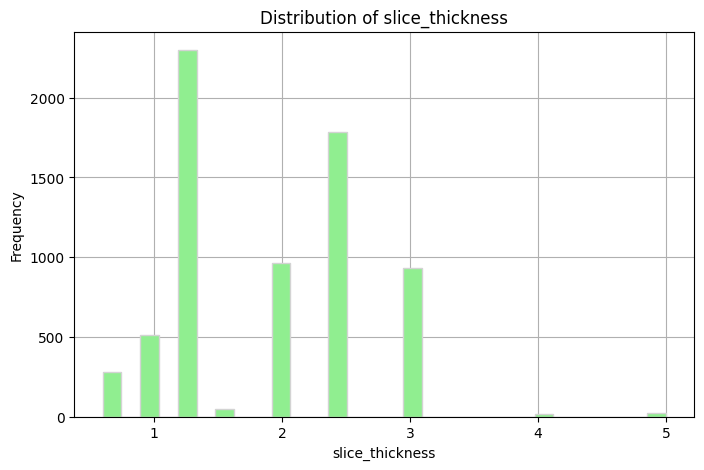

In [20]:
plot_feature_distribution(df_pylidc, 'slice_thickness', False)

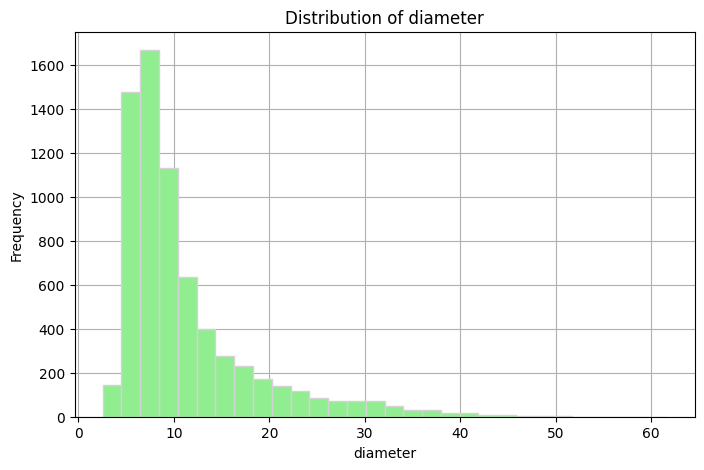

In [19]:
plot_feature_distribution(df_pylidc, 'diameter', False)

In [23]:
# plot_feature_distribution(df_pylidc, 'surface_area', False)

In [15]:
# Define a target label decoder
malignancyDecoder = {
    1:'Highly Unlikely',
    2:'Moderately Unlikely',
    3:'Indeterminate',
    4:'Moderately Suspicious',
    5:'Highly Suspicious'
}

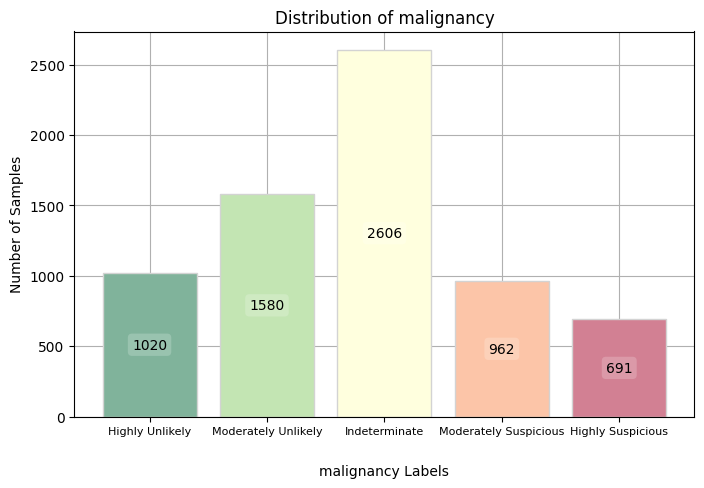

In [16]:
# Plot Malignancy class distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, malignancyDecoder)

As we can observe from the Distribution of Malignancy on the Population there are two main important aspects:

<td>&nbsp;&nbsp;&rightarrow; Target Class Distribution
    <dd>Most nodule's annotations seem to be indeterminate which does not improve the information used in the model's development. Therefore, we considered removing all the respective entries.</dd>
</td>
<td>&nbsp;&nbsp;&rightarrow; Multi-Class Classification
    <dd>Due to the complexity inherent to a multi-class classification problem, we aim to adapt it into a binary classification problem.</dd>
</td>

#### Target Class Distribution

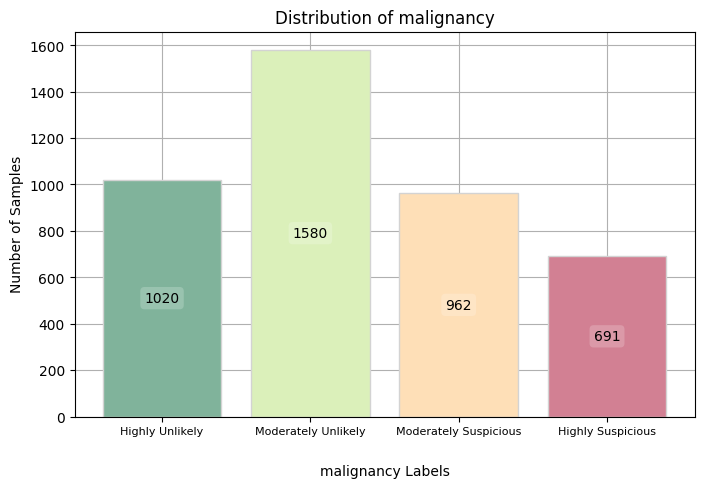

In [17]:
# Remove neutral cases from the dataset
df_pylidc = df_pylidc.loc[df_pylidc['malignancy'] != 3]

# Plot the updated target feature distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, malignancyDecoder)

#### Target Label Binarization

In [18]:
# Create a target decoder to visualize the binary target labels
targetDecoder = {
    0:'Highly Unlikely',
    1:'Highly Suspicious'
}

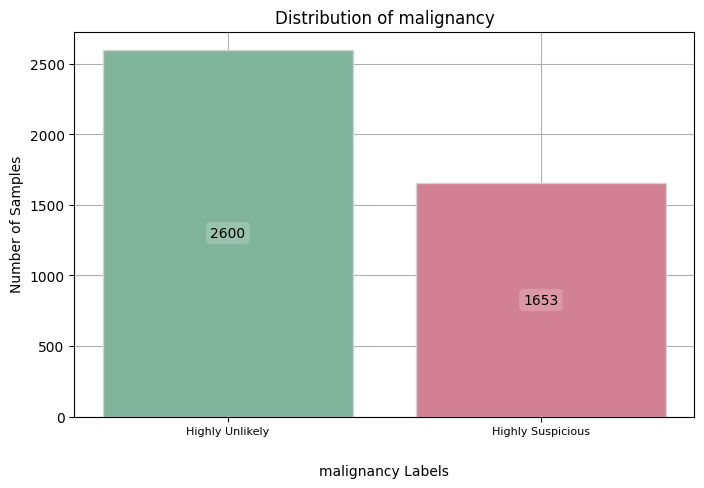

In [19]:
# Perform Binarization
df_pylidc['malignancy'] = df_pylidc['malignancy'].apply(lambda x: 0 if x <= 2 else 1)

# Plot the updated target feature distribution
plot_feature_distribution(df_pylidc, 'malignancy', True, targetDecoder)

---
## Feature Engineering
---

> WHAT DOES FEATURE ENGINEERING INTENDED TO ADD TO THE PROJECT AND HOW
> EXTRACT ADDITIONAL IMPORTANT FEATURES FROM THE PYRADIOMICS LIBRARY

---
### Pyradiomics Features Dataset
---

> Describe the whole process to obtain a dataset with the pyradiomics features

> Describe the extraction setup and what we aim to gain from it. What was used (Packages, other resources, ....)
> Perform the extraction with the images and merge the results with the previous dataset
> Clean the Data and save it

---
#### [Pyradiomics] Feature Extraction
---

In [20]:
# Variable to determine if we perform feature extration using the pyradiomics package
extractPyradiomicsFeatures = False

# Perform Pyradiomics Feature Extraction
if extractPyradiomicsFeatures:
    files_path = 'c:\\Insert\\Global\\Path\\To\\LIDC-IDRI'
    extractPyradiomicsFeatures(Lidc_IdrFilesPath=files_path,
                               pyradiomicsDcmScriptPath='./pyradiomics-dcm.py',
                               pyradiomicsParamsFilePath='./Pyradiomics_Params.yaml',
                               pyradiomicsFeatureDictFilePath='./featuresDict.tsv',
                               startPatient=0,
                               outputDirectoryPath='./OutputSR',
                               tempDirectoryPath='./TempDir')

In [24]:
# Load the Dataset
df_pyradiomics = pd.read_csv('pyradiomics_features.csv', index_col=False)
df_pyradiomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Columns: 1599 entries, annotation_id to logarithm_ngtdm_Strength
dtypes: float64(1565), int64(4), object(30)
memory usage: 57.2+ MB


In [25]:
# Check the dataframe dimensions
rows, cols = df_pyradiomics.shape
print(f"The pyradiomics feature dataset contains {rows} rows and {cols} cols")

The pyradiomics feature dataset contains 4688 rows and 1599 cols


In [26]:
# Inspect the first rows from the dataset
df_pyradiomics.head()

,annotation_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214
3,LIDC-IDRI-0001-4,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.103967,0.018713,0.463454,710.169563,0.008608,0.134292,0.002153,35828.160714,7.225162,14.078258
4,LIDC-IDRI-0002-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,75.851878,0.455616,0.104524,126.985909,0.012662,0.792276,0.007417,3154.963087,0.988412,55.765308


---
#### [Pyradiomics] Feature Cleaning and Processing
---

In [27]:
# Clean the Dataframe [NEEDS CHECKING]
df_pyradiomics = pd.read_csv('pyradiomics_features.csv', index_col=False)
df_pyradiomics.iloc[:, 143:] = df_pyradiomics.iloc[:, 143:].apply(lambda x: x.shift(273) if x.isna().any() else x, axis=1)
df_pyradiomics = df_pyradiomics.sort_values(df_pyradiomics.columns[0])
df_pyradiomics = df_pyradiomics.reset_index(drop=True)
df_pyradiomics.head()

,annotation_id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214
3,LIDC-IDRI-0001-4,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.103967,0.018713,0.463454,710.169563,0.008608,0.134292,0.002153,35828.160714,7.225162,14.078258
4,LIDC-IDRI-0002-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,75.851878,0.455616,0.104524,126.985909,0.012662,0.792276,0.007417,3154.963087,0.988412,55.765308


In [30]:
np.unique(df_pyradiomics['diagnostics_Image-original_Dimensionality'])

array(['3D'], dtype=object)

In [29]:
list(df_pyradiomics.columns)

['annotation_id',
 'diagnostics_Versions_PyRadiomics',
 'diagnostics_Versions_Numpy',
 'diagnostics_Versions_SimpleITK',
 'diagnostics_Versions_PyWavelet',
 'diagnostics_Versions_Python',
 'diagnostics_Configuration_Settings',
 'diagnostics_Configuration_EnabledImageTypes',
 'diagnostics_Image-original_Hash',
 'diagnostics_Image-original_Dimensionality',
 'diagnostics_Image-original_Spacing',
 'diagnostics_Image-original_Size',
 'diagnostics_Image-original_Mean',
 'diagnostics_Image-original_Minimum',
 'diagnostics_Image-original_Maximum',
 'diagnostics_Mask-original_Hash',
 'diagnostics_Mask-original_Spacing',
 'diagnostics_Mask-original_Size',
 'diagnostics_Mask-original_BoundingBox',
 'diagnostics_Mask-original_VoxelNum',
 'diagnostics_Mask-original_VolumeNum',
 'diagnostics_Mask-original_CenterOfMassIndex',
 'diagnostics_Mask-original_CenterOfMass',
 'diagnostics_Image-interpolated_Spacing',
 'diagnostics_Image-interpolated_Size',
 'diagnostics_Image-interpolated_Mean',
 'diagnosti

In [25]:
# df_pyradiomics = pd.read_csv('pyradiomics_features.csv', index_col=False)
# df_pyradiomics

---
### Final Features Dataset
---

> MERGE PREVIOUS DATASETS IN ORDER TO CREATE THE ONE WHICH WE ARE GOING TO USE TO TRAIN THE MODELS

In [26]:
# Merge both datasets and clean them
# pd.merge(df_pyradiomics, df_pylidc, on='annotation_id')

In [27]:
# Remove rows with at least one null / NaN Value
# df = df.dropna(how='any')

In [30]:
# CHECK FOR NULL VALUES
# df_clean = df[df['feat'].isnull() == False]
# df_clean = df[df['feat'].isna() == False]

---
## Model Development
---

> SELECT THE ML ALGORITHMS AND WHY
> AUTOMATE A SIMPLE PIPELINE TO TRAIN-TEST THE MODELS BY SPLITTING THE DATA
> PERFORM GRID SEARCH FOR A AUTOMATED HYPER-PARAMETER TUNNING 

---
## Performance Evaluation
---

> SELECT METRICS USED
> PLOT CONFUSION MATRICES, LEARNING CURVES, ...
> PERFORM A STATISTICAL EVALUATION OF THE MODEL'S RESULTS TO PROPERLY COMPARE THE PERFORMACE OF EACH ML ALGORITHM

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=CjDTJSvi37Fyu1kU)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`

---
---
---
---

## TODO:
- Identify and Describe the Problem
- Identify the business, its goals and possible constraints for the solution and the used pipeline
- Weight the 2D vs 3D image processing paradigm and choose which one to use and why

<br/>

- Perform Exploratory Data Analysis [Class Imbalance, Check type of problem - if we can switch from multi-class to binary classification, maybe perform synthetic sampling or data prunning, If there is a lot of data maybe consider a PCA to reduce processing costs]
- Select Algorithms and the reasons behind the choice
- Split the data based on a K-Fold Cross Validation Stratigy
- Perform Grid Search for parameter tunning on each one of the algorithms
- Train the model with the best hyperparameters found and evaluate the performance based on multiple metrics [balanced accuracy, f1-score, ...]
- Perform a statistical evaluation on the model's performance
- Does it achieve the business goals and at what costs?
- Ethical Considerations and identify possible privacy breaches (even though the data is anonimized)
- YouTube Presentation Video
- Bibliographic References

In [28]:
# df_pyradiomics = df_pyradiomics.rename(columns = {'nodule_id':'annotation_id'})
# df_pyradiomics.to_csv('./pyradiomics_features.csv', sep=',', index=False)